<a href="https://www.kaggle.com/code/averma111/ps-s3-e13-pytorch?scriptVersionId=127113410" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
ROOT_PATH='/kaggle/input/playground-series-s3e13'
train =  pd.read_csv(ROOT_PATH+'/train.csv')
test =  pd.read_csv(ROOT_PATH+'/test.csv')
train.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


In [9]:
def dataset_summary(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary['Null'] = df.isnull().sum()
    summary['Unique'] = df.nunique()
    summary['min'] = df.min()
    summary['median'] = df.median()
    summary['max'] = df.max()
    summary['mean'] = df.mean()
    summary['std'] = df.std()
    
    return summary

In [10]:
dataset_summary(train)

,dtypes,Null,Unique,min,median,max,mean,std
id,int64,0,707,0,353.0,706,353.000000,204.237607
sudden_fever,float64,0,2,0.0,1.0,1.0,0.503536,0.500341
headache,float64,0,2,0.0,0.0,1.0,0.449788,0.497825
mouth_bleed,float64,0,2,0.0,0.0,1.0,0.459689,0.498725
nose_bleed,float64,0,2,0.0,0.0,1.0,0.487977,0.500209
...,...,...,...,...,...,...,...,...
ulcers,float64,0,2,0.0,0.0,1.0,0.144272,0.351614
toenail_loss,float64,0,2,0.0,0.0,1.0,0.137199,0.344301
speech_problem,float64,0,2,0.0,0.0,1.0,0.032532,0.177533
bullseye_rash,float64,0,2,0.0,0.0,1.0,0.031117,0.173758


ValueError: could not convert string to float: 'Lyme_disease'

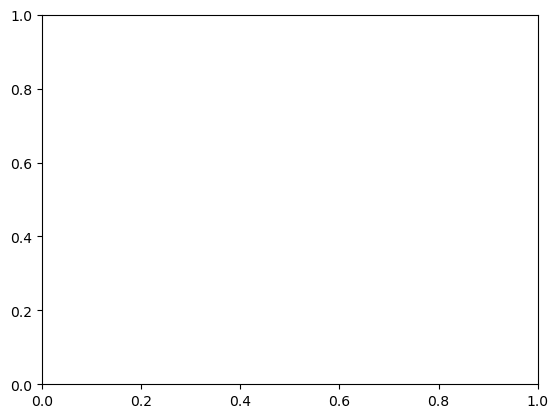